# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import os       
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',20)

In [2]:
from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss

from sklearn.model_selection import GridSearchCV

In [3]:
os.chdir('/content/drive/MyDrive/data/open')

# Read in the data files

In [4]:
train = pd.read_csv('train.csv', index_col='index')
test = pd.read_csv('test.csv', index_col='index')
submission = pd.read_csv('sample_submission.csv', index_col='index')

# 데이터 변수 설명


gender: 성별


car: 차량 소유 여부


reality: 부동산 소유 여부


child_num: 자녀 수


income_total: 연간 소득


income_type: 소득 분류


    ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']



edu_type: 교육 수준


        ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']



family_type: 결혼 여부


    ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']



house_type: 생활 방식


    ['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']



DAYS_BIRTH: 출생일


							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미



DAYS_EMPLOYED: 업무 시작일


							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미

													

							양수 값은 고용되지 않은 상태를 의미함



FLAG_MOBIL: 핸드폰 소유 여부


work_phone: 업무용 전화 소유 여부


phone: 전화 소유 여부


email: 이메일 소유 여부


occyp_type: 직업 유형													


family_size: 가족 규모


begin_month: 신용카드 발급 월
			

							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미







credit: 사용자의 신용카드 대금 연체를 기준의 신용도


							=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함

# EDA

In [5]:
train.columns = train.columns.str.lower()

In [6]:
train['flag_mobil'] = train['flag_mobil'].astype('object')
train['work_phone'] = train['work_phone'].astype('object')
train['phone'] = train['phone'].astype('object')
train['email'] = train['email'].astype('object')

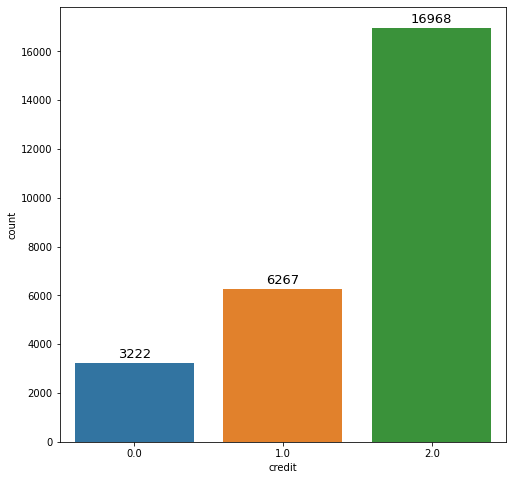

In [7]:
fig,ax = plt.subplots(figsize=(8,8))

sns.countplot(x='credit',data=train,ax=ax)

for i in train['credit'].unique() : 
    height = train['credit'].value_counts()[i]
    ax.annotate(height,xy=(i,height),xytext=(0,2),
              textcoords="offset points",ha='center',va='bottom',fontsize=13)
plt.show()

In [8]:
cat_features = train.dtypes[train.dtypes=='object'].index.tolist()
cont_features = train.columns.difference(cat_features+['credit'])
target = ['credit']

In [9]:
for col in cat_features :
    print(col,": ",train[col].nunique())

gender :  2
car :  2
reality :  2
income_type :  5
edu_type :  5
family_type :  5
house_type :  6
flag_mobil :  1
work_phone :  2
phone :  2
email :  2
occyp_type :  18


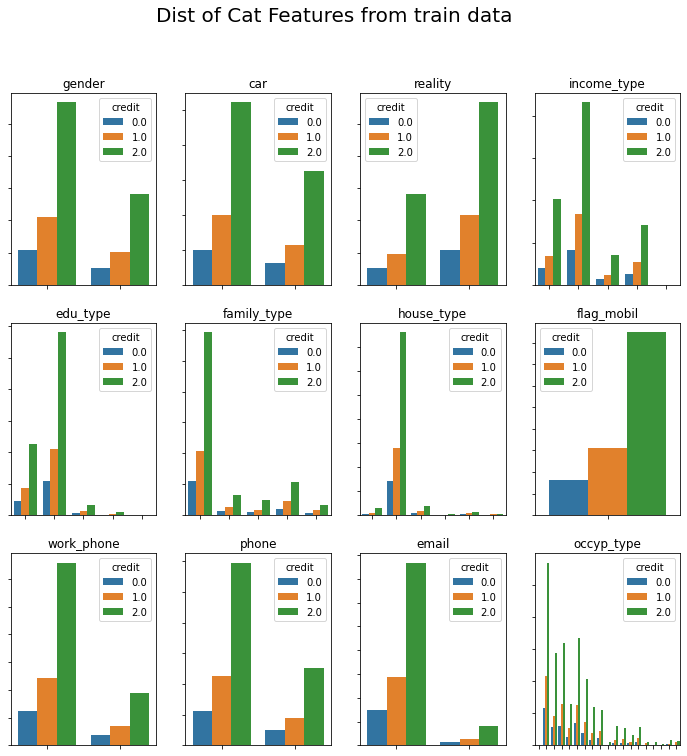

In [10]:
fig,ax = plt.subplots(3,4,figsize = (12,12))

fig.suptitle('Dist of Cat Features from train data', fontsize=20)

for idx,col in enumerate(cat_features) :
    i,j = divmod(idx,4)
    sns.countplot(x=col,data=train,ax=ax[i,j],order=train[col].unique(),hue='credit')
    ax[i,j].set_xlabel("")
    ax[i,j].set_ylabel("")
    ax[i,j].set_yticklabels("")
    ax[i,j].set_xticklabels("")
    # ax[i,j].set_xticklabels(ax[i,j].get_xticklabels(),rotation=45)
    # ax[i,j].set_xticks([])
    ax[i,j].set_title(col);

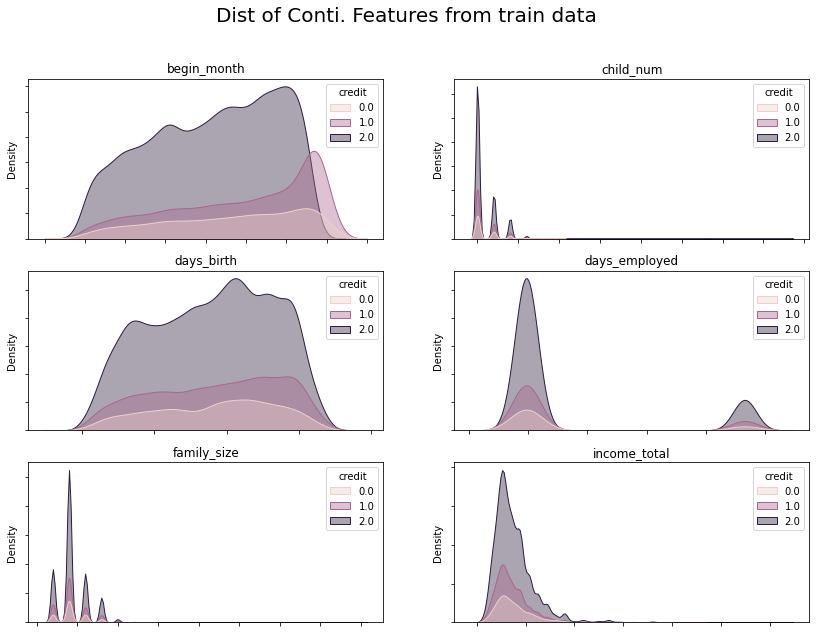

In [11]:
fig,ax = plt.subplots(3,2,figsize = (14,10))

fig.suptitle('Dist of Conti. Features from train data', fontsize=20)

for idx,col in enumerate(cont_features) :
    i,j = divmod(idx,2)
    sns.kdeplot(x=col,data=train,ax=ax[i,j],shade=True,hue='credit',alpha=.4)
    ax[i,j].set_xticklabels("")
    ax[i,j].set_yticklabels("")
    ax[i,j].set_xlabel("")
    ax[i,j].set_title(col);

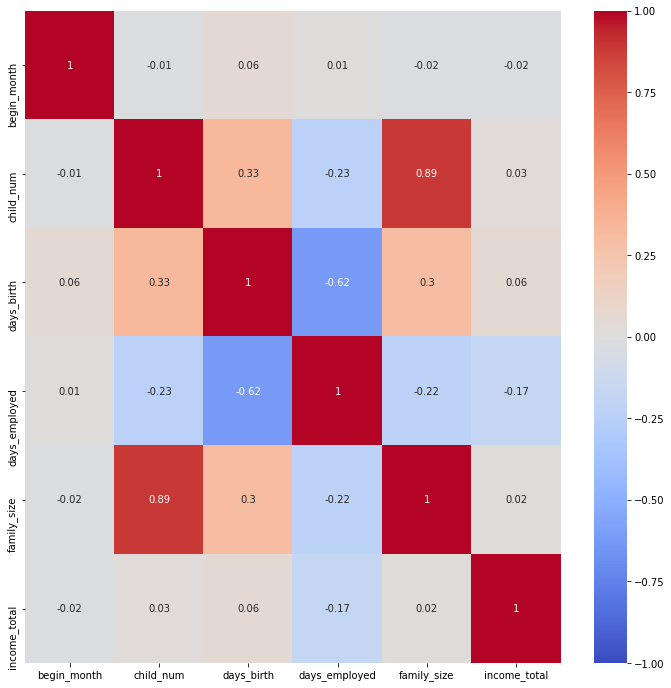

In [12]:
fig,ax = plt.subplots(figsize=(12,12))

cor = np.round(train[cont_features].corr(),2)
sns.heatmap(cor,vmin=-1,vmax=1,cmap='coolwarm',annot=True);

# Feature Engineering

In [13]:
dat = train.copy()

dat.columns = dat.columns.str.lower()

dat['days_birth'] = -1*dat['days_birth']
dat['days_employed'] = -1*dat['days_employed']
dat['begin_month'] = -1*dat['begin_month'] 

dat['days_employed'] = np.where(dat['days_employed']<0,0,dat['days_employed'])
 
dat['occyp_type'] = dat['occyp_type'].fillna('white')

dat['work_phone'] = dat['work_phone'].astype('object')
dat['phone'] = dat['phone'].astype('object') 
dat['email'] = dat['email'].astype('object')

cat_features = dat.dtypes[dat.dtypes == 'object'].index.tolist()

edu_dict = {'Academic degree' : 5,
            'Higher education' : 4,
            'Incomplete higher' : 3,
            'Secondary / secondary special' : 2,
            'Lower secondary' : 1
            }

tmp = dat.groupby(['income_type'], as_index=False).agg({'income_total':['mean','std','min','max']})
income_type_mean_dict = dict(tmp.iloc[:,[0,1]].values)
income_type_std_dict = dict(tmp.iloc[:,[0,2]].values)
income_type_min_dict = dict(tmp.iloc[:,[0,3]].values)
income_type_max_dict = dict(tmp.iloc[:,[0,4]].values)

tmp = dat.groupby(['edu_type'], as_index=False).agg({'income_total':['mean','std','min','max']})
edu_type_mean_dict = dict(tmp.iloc[:,[0,1]].values)
edu_type_std_dict = dict(tmp.iloc[:,[0,2]].values)
edu_type_min_dict = dict(tmp.iloc[:,[0,3]].values)
edu_type_max_dict = dict(tmp.iloc[:,[0,4]].values)

tmp = dat.groupby(['house_type'], as_index=False).agg({'income_total':['mean','std','min','max']})
house_type_mean_dict = dict(tmp.iloc[:,[0,1]].values)
house_type_std_dict = dict(tmp.iloc[:,[0,2]].values)
house_type_min_dict = dict(tmp.iloc[:,[0,3]].values)
house_type_max_dict = dict(tmp.iloc[:,[0,4]].values)

tmp = dat.groupby(['family_type'], as_index=False).agg({'income_total':['mean','std','min','max']})
family_type_mean_dict = dict(tmp.iloc[:,[0,1]].values)
family_type_std_dict = dict(tmp.iloc[:,[0,2]].values)
family_type_min_dict = dict(tmp.iloc[:,[0,3]].values)
family_type_max_dict = dict(tmp.iloc[:,[0,4]].values)

tmp = dat.groupby(['reality'], as_index=False).agg({'income_total':['mean','std','min','max']})
reality_type_mean_dict = dict(tmp.iloc[:,[0,1]].values)
reality_type_std_dict = dict(tmp.iloc[:,[0,2]].values)
reality_type_min_dict = dict(tmp.iloc[:,[0,3]].values)
reality_type_max_dict = dict(tmp.iloc[:,[0,4]].values)

dat['email'] = np.where(dat['email']==1,"Y","N")
tmp = dat.groupby(['email'], as_index=False).agg({'income_total':['mean','std','min','max']})
email_type_mean_dict = dict(tmp.iloc[:,[0,1]].values)
email_type_std_dict = dict(tmp.iloc[:,[0,2]].values)
email_type_min_dict = dict(tmp.iloc[:,[0,3]].values)
email_type_max_dict = dict(tmp.iloc[:,[0,4]].values)

tmp = dat.groupby(['gender','edu_type'], as_index=False).agg({'income_total':['mean','std']}).fillna(0)
idx = ["_".join([a,b]) for a,b in zip(tmp.iloc[:,0],tmp.iloc[:,1])]
tmp = pd.DataFrame(tmp.iloc[:,2:].values, index=idx).reset_index()
gender_edu_type_mean_dict = dict(tmp.iloc[:,[0,1]].values)
gender_edu_type_std_dict = dict(tmp.iloc[:,[0,2]].values)

In [14]:
# # Freq Encoding
# lst = []
# for i,row in dat.iterrows():
#     lst.append("_".join([row['gender'], str(row['days_birth']), str(row['days_employed'])]))
# dat['id'] = lst

# N = dat['id'].nunique()
# gender_freq_enc = dat.groupby('gender')['id'].nunique()/N
# car_freq_enc = dat.groupby('car')['id'].nunique()/N
# reality_freq_enc = dat.groupby('reality')['id'].nunique()/N
# income_type_freq_enc = dat.groupby('income_type')['id'].nunique()/N
# family_type_freq_enc = dat.groupby('family_type')['id'].nunique()/N
# house_type_freq_enc = dat.groupby('house_type')['id'].nunique()/N
# work_phone_freq_enc = dat.groupby('work_phone')['id'].nunique()/N
# phone_freq_enc = dat.groupby('phone')['id'].nunique()/N
# email_freq_enc = dat.groupby('email')['id'].nunique()/N
# occyp_type_freq_enc = dat.groupby('occyp_type')['id'].nunique()/N

### Feature engineering pipeline

- 참고한 노트북

    - [rollcake](https://www.dacon.io/competitions/official/235713/codeshare/2526?page=1&dtype=recent)님 코드.

In [15]:
seed_num = 42
NUM_FOLDS = 10

In [16]:
def feature_pipeline(df):
    
    # 컬럼명 소문자화
    df.columns = df.columns.str.lower()

    # 범주형 변수 type 변경
    df['work_phone'] = np.where(df['work_phone']==1,"Y","N")
    df['phone'] = np.where(df['phone']==1,"Y","N")
    df['email'] = np.where(df['email']==1,"Y","N")
    
    # 부호 변경
    df['days_birth'] = -1*df['days_birth']
    df['days_employed'] = -1*df['days_employed']
    df['days_employed'] = np.where(df['days_employed']<0,0,df['days_employed'])
    df['begin_month'] = -1*df['begin_month'] 

    # 열 제거
    df = df.drop(['flag_mobil'],axis=1) 

    # 결측치 
    df['occyp_type'] = df['occyp_type'].fillna('white') 

    # 재범주화
    new_occyp = ['white', 'Laborers', 'Managers','Core staff'] # 
    df['occyp_type'] = df['occyp_type'].apply(lambda x: np.where(x in new_occyp, x, 'others'))    
 
    # 새로운 features
    df['income_family_ratio'] = df['income_total']/df['family_size']
    df['income_birth_ratio'] = df['income_total']/df['days_birth']
    df['income_emp_ratio'] = df['income_total']/df['days_employed']
    df['birth_emp_ratio'] = df['days_birth']/df['days_employed']


    df['income_type_mean'] = df['income_type'].map(income_type_mean_dict)
    df['income_type_std'] = df['income_type'].map(income_type_std_dict) 
 
    df['edu_type_mean'] = df['edu_type'].map(edu_type_mean_dict) 
    df['edu_type_std'] = df['edu_type'].map(edu_type_std_dict)
   
    df['house_type_mean'] = df['house_type'].map(house_type_mean_dict)
    df['house_type_std'] = df['house_type'].map(house_type_std_dict) 
  
    df['family_type_mean'] = df['family_type'].map(family_type_mean_dict)
    df['family_type_std'] = df['family_type'].map(family_type_std_dict)
    
    df['reality_type_mean'] = df['reality'].map(reality_type_mean_dict)
    df['reality_type_std'] = df['reality'].map(reality_type_std_dict)
    
    df['email_type_mean'] = df['email'].map(email_type_mean_dict)
    df['email_type_std'] = df['email'].map(email_type_std_dict)
   

    aa = []
    bb = []
    for i,row in df.iterrows():
        aa.append(gender_edu_type_mean_dict["_".join([row['gender'], row['edu_type']])])
        bb.append(gender_edu_type_std_dict["_".join([row['gender'], row['edu_type']])])
    df['gender_edu_type_mean'] = aa
    df['gender_edu_type_std'] = bb


    # # rollcake님 코드 참고
    df['birth_month'] = (df['days_birth']//31)%12
    df['birth_week'] = (df['days_birth']//7)%4.3
    df['DAYS_EMPLOYED_month'] = (df['days_employed']//31)%12
    df['DAYS_EMPLOYED_week'] = (df['days_employed']//7)%4.3
    df['before_EMPLOYED'] = df['days_birth'] - df['days_employed']
    df['before_EMPLOYED_month'] = (df['before_EMPLOYED']//31)%12
    df['before_EMPLOYED_week'] = (df['before_EMPLOYED']//7)%4.3


    df['DAYS_BIRTH_weekday'] = df['days_birth']%7
    df['DAYS_BIRTH_days_in_month'] = df['days_birth']%31
    df['DAYS_BIRTH_day'] = (df['days_birth'])%365 
    df['DAYS_EMPLOYED_weekday'] = (df['days_employed'])%7 
    df['before_EMPLOYED_weekday'] = (df['before_EMPLOYED'])%7
    df['before_EMPLOYED_weekday_days_in_month'] = df['before_EMPLOYED']%31
    
    df['car+gender'] = (df['car'] + df['gender']).astype('object')

  
    # Ordinal encoding
    df['edu_type'] = df['edu_type'].apply(lambda x : edu_dict[x]).astype('int') 

    # One-hot encoding
    df = pd.get_dummies(data=df,drop_first=True) 

    return df


In [17]:
df_train = train.copy() 
df_test = test.copy()

df_train = feature_pipeline(df_train)
df_test = feature_pipeline(df_test)

features = df_train.columns.difference(['credit'])

X = df_train[features]
y = df_train['credit']
X_test = df_test[features]


## LGBM  

* (전체모델) `KFold` 보다 `StratifiedKFold`의 성능이 더 낮게 나옴.

* (성능) One-hot encoding  >  Label encoding 

**실험: One-hot encoding  v.s.  Label encoding**

    * 0.6931(One-hot) < 0.6937(Label)


In [19]:
lgbm_params = {
    "random_state": seed_num,
    "n_jobs": -1,
    "early_stopping_round": 100,

    "categorical_feature:name=" : cat_features,

    "metric": "multi_logloss",
    "objective" : "multiclass",

    "n_estimators": 1000,
    "learning_rate": 0.05,

    "max_depth": 18,   
    "num_leaves": 200,     
    "colsample_bytree": 0.5, 
    "max_bin": 100,
    "min_child_samples": 8, 

    "feature_fraction" : 0.3,
    # "lambda_l1" : 0.2,
    # "lambda_l2" : 0.2,

    'refit' : True,

}

In [20]:
train_oof = np.zeros((len(df_train),3))
test_preds = 0

kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=seed_num)
# kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=seed_num)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X, y))):
        tmp_train_df, tmp_val_df = X.iloc[train_ind], X.iloc[val_ind]
        train_target, val_target = y[train_ind], y[val_ind]
        
        model = LGBMClassifier(**lgbm_params)
        model.fit(
            tmp_train_df, 
            train_target, 
            eval_metric = 'multi_logloss',
            eval_set=[(tmp_val_df, val_target)], 
            early_stopping_rounds = 50, 
            verbose = False
        )
        
        temp_oof = model.predict_proba(tmp_val_df)
        temp_test = model.predict_proba(X_test)

        train_oof[val_ind,:] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
print(log_loss(y,train_oof))


0.680509961448073


In [21]:
tmp_lgbm = pd.DataFrame(test_preds,index=submission.index,columns=submission.columns)

In [22]:
# tmp_lgbm.to_csv('sub_lgbm.csv')